# Generate simulated PMT pulse

David Cussans , December 2025

First import the libraries we need

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Define routine that produces a power spectral density by interpolating from an array of values

In [2]:
def interpolate_psd(freqs_data, psd_data, n_samples, fs):
    """
    Interpolate measured PSD data onto FFT frequency grid.
    
    Parameters:
    -----------
    freqs_data : ndarray
        Frequencies of the measured PSD (Hz).
    psd_data : ndarray
        PSD values at freqs_data.
    n_samples : int
        Number of time samples.
    fs : float
        Sampling frequency (Hz).
    
    Returns:
    --------
    freqs_fft : ndarray
        FFT frequency bins.
    psd_interp : ndarray
        PSD values interpolated onto FFT bins.
    """
    freqs_fft = np.fft.rfftfreq(n_samples, 1/fs)
    psd_interp = np.interp(freqs_fft, freqs_data, psd_data, left=0, right=0)
    return freqs_fft, psd_interp

Given a PSD generate a time series of the noise

In [5]:
def noise_from_psd_array(psd_vals, n_samples=1024, fs=1.0):
    """
    Generate a noise time series with a given power spectral density (PSD array).
    """
    
    # Return the Discrete Fourier Transform sample frequencies (for usage with rfft, irfft).
    # d = Sample spacing (inverse of the sampling rate)
    freqs = np.fft.rfftfreq(n = n_samples, d = 1/fs)
    assert len(psd_vals) == len(freqs), "PSD array length mismatch"

    # Random phases
    random_phases = np.exp(1j * 2 * np.pi * np.random.rand(len(freqs)))

    # Amplitudes scaled by PSD
    amplitudes = np.sqrt(psd_vals * fs * n_samples / 2.0) * random_phases

    # Build Hermitian-symmetric full spectrum
    spectrum = np.zeros(n_samples, dtype=complex)
    spectrum[:len(amplitudes)] = amplitudes
    spectrum[-(len(amplitudes)-1):] = np.conj(amplitudes[1:][::-1])

    # Inverse FFT
    x = np.fft.ifft(spectrum).real
    t = np.arange(n_samples) / fs

    # Verify PSD
    Xf = np.fft.rfft(x)
    psd_est = (np.abs(Xf) ** 2) / (fs * n_samples)

    return t, x, freqs, psd_est

Use the routines to generate a time series of noise with a given PSD

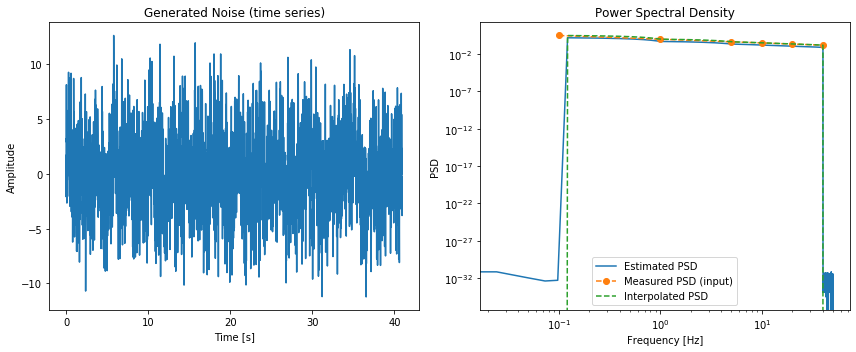

In [11]:
if __name__ == "__main__":
    fs = 100.0     # Sampling frequency (Hz)
    n_samples = 4096

    # Example "measured" PSD (say, pink noise, but sampled sparsely)
    freqs_measured = np.array([0.1, 1, 5, 10, 20, 40])
    psd_measured = 1.0 / freqs_measured**0.5  # just a toy example

    # Interpolate onto FFT grid
    freqs_fft, psd_vals = interpolate_psd(freqs_measured, psd_measured, n_samples, fs)

    # Generate noise
    t, x, freqs, psd_est = noise_from_psd_array(psd_vals, n_samples, fs)

    # Plot
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(t, x)
    plt.title("Generated Noise (time series)")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")

    plt.subplot(1,2,2)
    plt.loglog(freqs, psd_est, label="Estimated PSD")
    plt.loglog(freqs_measured, psd_measured, 'o--', label="Measured PSD (input)")
    plt.loglog(freqs, psd_vals, '--', label="Interpolated PSD")
    plt.title("Power Spectral Density")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("PSD")
    plt.legend()
    plt.tight_layout()
    plt.show()